## Time Cost of Population Generation 

This notebook will examine the time taken to generate an initial population as compared with the time taken to run the GA with either maximum 20 generations or stability (convergence) for ten generations with graphs of increasing size: 100, 225, 500 nodes. 

In [5]:
import time 
import random
import numpy as np
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt

In [1]:
# Function to generate an erdos renyi G(n, p) graph as a 
# networkx object 
def erdos_renyi(n, p):
    # Create an empty networkx graph
    G = nx.Graph()
    
    # Add n nodes
    G.add_nodes_from(range(n))
    
    # Add possible edges with probability p
    # Disallow self-edges
    for i in range(n):
        for j in range(n):
            if i == j:
                continue 
            
            rnd = random.random()
            
            if rnd < p:
                G.add_edge(i, j)
    
    return G

In [7]:
# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w = None):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

In [11]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))


def fit(p, g):
    return path_length(p, g) ** (-1)


# Function to define a single new random path from node s to node r
# in a network supplied as a Networkx graph 
# G: Graph / network as networkx
# s: Start node 
# r: Destination node 
def gen_path(G, s, r):
    path = [s]
    
    current = s
    while current != r: 
        # Neighbours exluding nodes in path 
        neighbours = [n for n in G[current] if n not in path]
        
        # Sometimes, neighbours is empty 
        # In which case, retry 
        if not neighbours:
            return gen_path(G, s, r)
        
        # Select neighbour node with uniform probability  
        nxt = np.random.choice(neighbours) 
        
        # List and visit next node 
        path.append(nxt)
        current = nxt 
        
    return path

# Function to generate a population of n random paths s->r
# G: Graph as networkx
# s: Start node
# r: Destination node
# n: Number of paths / size of population 
def gen_population(G, s, r, n):
    population = [] 
    for i in range(n):
        # Generate a new candidate path
        candidate = gen_path(G, s, r)
        # Generate a new candidate 
        population.append(candidate)
    
    return population

# Perform crossover between two paths s->r
# The two paths must have at least one common element 
# From the set of common elements, one is selected, v 
# The paths are redifined as s -> v, v -> r  
# The path segments are recombined to create two children
# a: The first path
# b: The second path 
def crossover(a, b):
    common = [] 
    for ind_a, i in enumerate(a):
        for ind_b, j in enumerate(b):
            if i == j:
                common.append((ind_a, ind_b))
    
    # Randomly select a one common element to exchange
    target = np.random.choice(len(common))
    
    # Retrieve indexes
    ind_a, ind_b = common[target]
    
    # Create new arrays
    chd_a = a[:ind_a] + b[ind_b:]
    chd_b = b[:ind_b] + a[ind_a:]
    
    return chd_a, chd_b

# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)


# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])
        

def mutate(G, path):
    # Select a random element in path, v
    ind = np.random.choice(len(path) - 1)
    
    # Create a new random path from v to destination 
    v = path[ind]
    rnd_path = gen_path(G, v, path[-1])
    
    return path[:ind] + rnd_path


# *** MODIFIED TO RETURN TWO TIME RESULTS *** 
# threshold: Number of iterations with unchanged best fitness before exit 
# itr: Maximum number of iterations before quit 
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# s: start node in path 
# d: destination node in path
# g; graph 
def ga(G, threshold, itr, p, r, m, s, d):
    # Store the history of max and mean fitness for generations 
    history = []
    
    # Take starting time 
    gen_pop_start = time.time()
    
    # Generate a random population 
    # Graph; start node; dest node; size of population 
    population = gen_population(G, s, d, p) 
    gen_pop_time = time.time() - gen_pop_start 
    
    run_ga_start = time.time()
    fitness, fmax, ftotal, favg = evaluate(population, G)
    
    # Track previo
    # Generations 
    count = 0
    unchanged = 0 
    while  (unchanged < threshold) and (count < itr):   
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            c, d = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(c) 
            gen.append(d)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = mutate(G, gen[i]) 
        
        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the current population fitness
        _fmax = fmax
        fitness, fmax, ftotal, favg = evaluate(population, G)
        
        # Check if maximum fitness solution has changed 
        if _fmax == fmax:
            unchanged += 1 
        else:
            unchanged = 0 # Reset when max fitness changes 
        
        # Increment generation count
        count += 1 
    
    # Return stats and performance 
    ind = np.argmax(fitness)
    run_ga_time = time.time() - run_ga_start 
    
    results = {"generations": count, 
               "gen_pop_time": gen_pop_time,
               "run_ga_time": run_ga_time, 
               "learning_history": history, 
               "solution": population[ind], 
               "length": path_length(population[ind], G), 
               "fitness": fitness[ind]}
    
    return results 

**Test: Time to Generate Population and Run GA for Erdos-Renyi Graphs of 100, 225, 500 nodes** 

In [8]:
G_small = erdos_renyi(100, 0.4)
G_medium = erdos_renyi(225, 0.4)
G_large = erdos_renyi(500, 0.4)

assign_random_weights(G_small, 0, 100)
assign_random_weights(G_medium, 0, 100)
assign_random_weights(G_large, 0, 100)

In [12]:
# GA Hyperparameters 
THRESHOLD = 10          # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 20       # Maximum iterations 
P_SIZE = 100            # Size of population 
M_RATE = 0.025           # Mutation rate (percent of population to mutate)
R_RATE = 0.5            # Percent of population to select as parents

# Nominal src, destination nodes for each graph size 
# The choice of src and destination is not significant for ER-Random graph 
src_small, dst_small = 25, 75
src_medium, dst_medium = 25, 175
src_large, dst_large = 25, 375

# Run the GA for each graph 
results_small = ga(G_small, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, src_small, dst_small)
results_medium = ga(G_medium, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, src_medium, dst_medium)
results_large = ga(G_large, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, src_large, dst_large)

**Plot Runtime for Population Generation and GA**

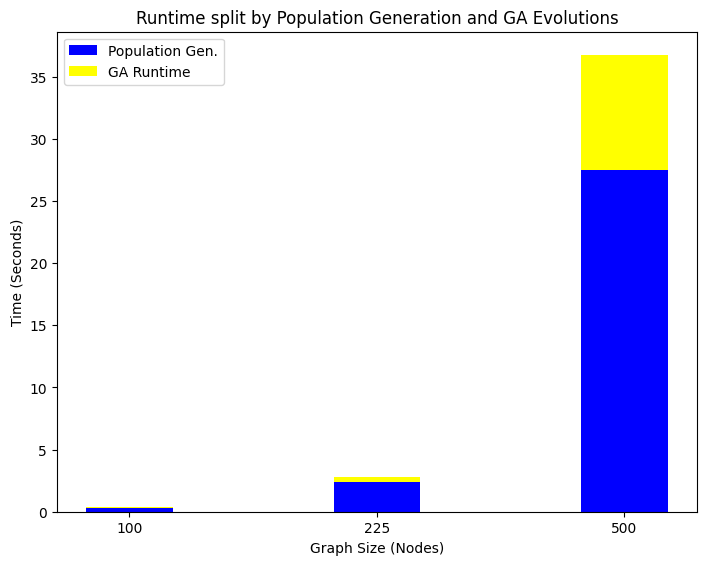

In [17]:
N = 3
pop_gen_times = [results_small["gen_pop_time"], results_medium["gen_pop_time"], results_large["gen_pop_time"]]
run_ga_times = [results_small["run_ga_time"], results_medium["run_ga_time"], results_large["run_ga_time"]]


ind = np.arange(N) # x locations for bars
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(ind, pop_gen_times, width, color = 'blue')
ax.bar(ind, run_ga_times, width, bottom = pop_gen_times, color = 'yellow')
ax.set_ylabel('Time (Seconds)')
ax.set_title("Runtime split by Population Generation and GA Evolutions")
ax.set_xticks(ind, ("100", "225", "500"))
ax.set_xlabel("Graph Size (Nodes)")
ax.legend(labels=['Population Gen.', 'GA Runtime'])
plt.show()